<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Quick-Introduction-to-Okapi-BM25" data-toc-modified-id="Quick-Introduction-to-Okapi-BM25-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quick Introduction to Okapi BM25</a></span><ul class="toc-item"><li><span><a href="#Gaining-Intuition-for-Okapi-BM25" data-toc-modified-id="Gaining-Intuition-for-Okapi-BM25-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Gaining Intuition for Okapi BM25</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#ElasticSearch-BM25" data-toc-modified-id="ElasticSearch-BM25-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>ElasticSearch BM25</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# os.chdir(path)
import os
import math
import json
import requests
import numpy as np 
import pandas as np 
import json
# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
# %load_ext watermark
# %load_ext autoreload
# %autoreload 2
# %watermark -a 'Ethen' -d -t -v -p requests

# Quick Introduction to Okapi BM25

The problem that **BM25 (Best Match 25)** tries to solve is similar to that of [TFIDF (Term Frequency, Inverse Document Frequency)](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/tfidf/tfidf.ipynb), that is representing our text in a vector space (it can be applied to field outside of text, but text is where it has the biggest presence) so we can search/find similar documents for a given document or query.

The gist behind TFIDF is that is relies on two main factors to determine whether a document is similar to our query.

- Term Frequency aka tf: how often does the term occur in the document? 3 times? 10 times?
- Inverse Document Frequency aka idf: measures how many documents the term appeared in. Inverse document frequency (1/df) then measures how special the term is. Is the term a very rare (occurs in just one doc) word? Or a relatively common one (occurs in nearly all the docs)?

Using these two factors, TFIDF measures the relative concentration of a term in a given piece of document. If the term is common in this article, but relatively rare elsewhere, then the TFIDF score will be high, and documents that have higher TFIDF score would be considered as very relevant to the search term.

BM25 improves upon TFIDF by casting relevance as a probability problem. A relevance score, according to probabilistic information retrieval, ought to reflect the probability a user will consider the result relevant. Instead of going through how the formula was derived, here we'll take a look a the formula and try to digest it to see why it makes some kind of sense.

## Gaining Intuition for Okapi BM25

**BM25 (Best Match 25)** function scores each document in a corpus according to the document's relevance to a particular text query. For a query $Q$, with terms $q_1, \ldots, q_n$, the BM25 score for document $D$ is:


\begin{align}
\mbox{BM25}(D, Q) = \sum_{i=1}^n IDF(q_i, D) \frac{f(q_i, D) \cdot (k_1 + 1)}{f(q_i) + k_1 \cdot (1-b + b \cdot |D|/d_{avg}))}
\end{align}

where:

- $f(q_i, D)$ is the number of times term $q_i$ occurs in document $D$.
- $|D|$ is the number of words in document $D$.
- $d_{avg}$ is the average number of words per document.
- $b$ and $k_1$ are hyperparameters for BM25.

Let's break the formula down into smaller components to see why it makes sense.

- First of all, there's $f(q_i, D)$ and $k_1$. $f(q_i, D)$ should match our intuition, as this means the more times the query term appears in the document, the higher the document's score will be. The interesting part is the **parameter $k_1$, which determines the term frequency saturation characteristic. The higher the value, the slower the saturation.** And when we say saturation, we are referring to the fact that if terms occurring extra times add extra score. We can observe this diminishing return in term frequency from the graph below.

<img src="./tf_comparison.png" width="70%" height="70%">

- Then $|D|/d_{avg}$ part in the denominator means a document that is longer than the average documents will result in a bigger denominator, resulting in a decrease in the score. The intuition is that the more terms in the document that does not match our input query - the lower the document's score should be. In other words, if a 300 page long document mentions the query term once, it's less likely to have as much to do with the query compared to a short tweet which mentions query once.

<img src="./doc_len_comparison.png" width="70%" height="70%">

From the graph above, we can see that shorter documents hit the asymptote much faster. Hopefully, this resembles our intuition as the more matches we have on shorter documents, the more certain we are about the relevance, whereas, for a lengthy book, it might take us longer to get to a point where we feel confident that the book is indeed relevant to the given query.

- The parameter $b$ (bound 0.0 ~ 1.0) in the denominator is multiplied by the ratio of the document length we just discussed. **If $b$ is bigger, the effects of the document length compared to the average length are more amplified.** We can imagine if we set $b$ to 0, the effect of the length ratio would be completely nullified.

As for the inverse document frequency part, ${IDF}(q_i, D)$. For a corpus with $N$ documents, inverse document frequency for term $q_i$ is computed as follows:

\begin{align}
\mbox{IDF}(q_i, D) = \log \frac{N - N(q_i) + 0.5}{N(q_i) + 0.5}
\end{align}

where

- $N(q_i)$ is the number of documents in the corpus that contain term $q_i$.

The inverse document frequency part is very similar to that of TFIDF, whose role is to make sure that rarer words will have a higher score and contribute more to the final score.

Please note that the IDF formula listed above has a drawback when using it for terms appearing in more than half of the corpus since the value would come out as negative value, resulting in the overall score to become negative. e.g. if we have 10 documents in the corpus, and the term "the" appeared in 6 of them, its IDF would be $log(10 - 6 + 0.5 / 6 + 0.5) = log(4.5 / 6.5)$. Although we can argue that our implementation should have already removed these frequently appearing words as these words are mostly used to form a complete sentence and carry little meaning of note, different softwares/packages still make different adjustments to prevent a negative score from ever occurring. e.g.

- Add a 1 to the equation.

\begin{align}
\mbox{IDF}(q_i) = \log \big( 1 + \frac{N - N(q_i) + 0.5}{N(q_i) + 0.5} \big)
\end{align}

- For term that resulted in a negative IDF value, swap it with an small positive value, usually denoted as $\epsilon$

Like all hyperparameters in general, the default ones are usually a good starting point, and we should probably focus on tweaking other stuff before jumping into the rabbit hole of hyperparameter tuning. In the context of search, it might be making sure our ranking scores older documents lower in application such as news ranking. But if we were to start tuning, remember to always measure the performance of various settings and the following questions are general starting points that we can reference to.

- For $k_1$, we should be asking, "when do we think a term is likely to be saturated?" For very long documents like books, it's very likely to have a lot of different terms appear several times in a work, even when the term isn't the primary subject of the document. We may not want terms to be saturated as quickly in this situation, so the suggestion is that $k_1$ should generally trend toward larger numbers when the text is a lot longer and more diverse. On the opposite side of things, it's been suggested to set $k_1$ on the lower side. It's very unlikely that a collection of short tweets would have a term multiple times without being highly related to that term.
- For $b$, we should be asking, "when do we think a document is likely to be very long, and when should that hinder its relevance to a term?" Documents which are highly specific like engineering specifications or patents are lengthy in order to be more specific about a subject. Their length is unlikely to be detrimental to the relevance and lower $b$ may be more appropriate. On the other end of the spectrum, documents which touch on several different topics in a broad way — news articles (a political article may touch on economics, international affairs, and certain corporations), user reviews, etc. — often benefit by choosing a larger $b$ so that irrelevant topics to a user's search, including spam and the like, are penalized.

In [9]:
import pickle
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords (run this line once to download the stopwords)
import nltk
nltk.download('stopwords')

# Assuming 'data' is a list of dictionaries with a 'text' key
with open('./wiki_hard.pkl', 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data)

stop_words = set(stopwords.words('english'))

texts = [
    [word for word in word_tokenize(str(doc).lower()) if word not in stop_words]
    for doc in df['text']
]

# Now you can use 'df' as a regular pandas DataFrame and 'texts' for processed text
# texts

[nltk_data] Downloading package stopwords to /home/fwajid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# texts[0]

In [11]:
# # Extract text from the loaded data
# with open('wiki_hard_test_25-50.pkl', 'rb') as f:
#     data = pickle.load(f)
    
# corpus = [doc['text'] for group in data for doc in group['documents']]

# # Preprocess the text (remove stopwords)


## Implementation

In [12]:
# # we'll generate some fake texts to experiment with
# corpus = [
#     'Human machine interface for lab abc computer applications',
#     'A survey of user opinion of computer system response time',
#     'The EPS user interface management system',
#     'System and human system engineering testing of EPS',
#     'Relation of user perceived response time to error measurement',
#     'The generation of random binary unordered trees',
#     'The intersection graph of paths in trees',
#     'Graph minors IV Widths of trees and well quasi ordering',
#     'Graph minors A survey'
# ]


# # remove stop words and tokenize them (we probably want to do some more
# # preprocessing with our text in a real world setting, but we'll keep
# # it simple here)
# stopwords = set(['for', 'a', 'of', 'the', 'and', 'to', 'in'])
# texts = [
#     [word for word in document.lower().split() if word not in stopwords]
#     for document in corpus
# ]

# build a word count dictionary so we can remove words that appear only once
word_count_dict = {}
for text in texts:
    for token in text:
        word_count = word_count_dict.get(token, 0) + 1
        word_count_dict[token] = word_count

texts = [[token for token in text if word_count_dict[token] > 1] for text in texts]
# texts

In [13]:
class BM25:
    """
    Best Match 25.

    Parameters
    ----------
    k1 : float, default 1.5

    b : float, default 0.75

    Attributes
    ----------
    tf_ : list[dict[str, int]]
        Term Frequency per document. So [{'hi': 1}] means
        the first document contains the term 'hi' 1 time.

    df_ : dict[str, int]
        Document Frequency per term. i.e. Number of documents in the
        corpus that contains the term.

    idf_ : dict[str, float]
        Inverse Document Frequency per term.

    doc_len_ : list[int]
        Number of terms per document. So [3] means the first
        document contains 3 terms.

    corpus_ : list[list[str]]
        The input corpus.

    corpus_size_ : int
        Number of documents in the corpus.

    avg_doc_len_ : float
        Average number of terms for documents in the corpus.
    """

    def __init__(self, k1=1.5, b=0.75):
        self.b = b
        self.k1 = k1

    def fit(self, corpus):
        """
        Fit the various statistics that are required to calculate BM25 ranking
        score using the corpus given.

        Parameters
        ----------
        corpus : list[list[str]]
            Each element in the list represents a document, and each document
            is a list of the terms.

        Returns
        -------
        self
        """
        tf = []
        df = {}
        idf = {}
        doc_len = []
        corpus_size = 0
        for document in corpus:
            corpus_size += 1
            doc_len.append(len(document))

            # compute tf (term frequency) per document
            frequencies = {}
            for term in document:
                term_count = frequencies.get(term, 0) + 1
                frequencies[term] = term_count

            tf.append(frequencies)

            # compute df (document frequency) per term
            for term, _ in frequencies.items():
                df_count = df.get(term, 0) + 1
                df[term] = df_count

        for term, freq in df.items():
            idf[term] = math.log(1 + (corpus_size - freq + 0.5) / (freq + 0.5))

        self.tf_ = tf
        self.df_ = df
        self.idf_ = idf
        self.doc_len_ = doc_len
        self.corpus_ = corpus
        self.corpus_size_ = corpus_size
        self.avg_doc_len_ = sum(doc_len) / corpus_size
        return self

    def search(self, query):
        scores = [self._score(query, index) for index in range(self.corpus_size_)]
        return scores

    def _score(self, query, index):
        score = 0.0

        doc_len = self.doc_len_[index]
        frequencies = self.tf_[index]
        for term in query:
            if term not in frequencies:
                continue

            freq = frequencies[term]
            numerator = self.idf_[term] * freq * (self.k1 + 1)
            denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.avg_doc_len_)
            score += (numerator / denominator)
        return score

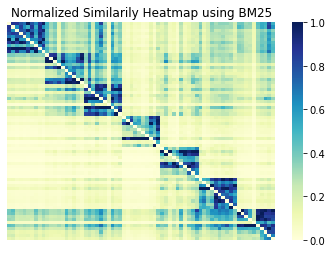

In [14]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

# 1. Initialize and Fit BM25
bm25 = BM25(k1=2.5, b=0.55)

bm25.fit(texts)  # Assuming 'texts' is your corpus

# 2. Compare Similarity Between Texts
num_texts = len(texts)
similarity_matrix = np.zeros((num_texts, num_texts))

for i in range(num_texts):
    for j in range(i + 1, num_texts):  # Avoid redundant comparisons
        # if i <1:
            # print(texts[j+2])
            # # print(i)
            
        # Compute BM25 similarity score between texts i and j
        score_ij = bm25._score(texts[j], i)
        similarity_matrix[i, j] = score_ij
        similarity_matrix[j, i] = score_ij  # Symmetric matrix

# # Optionally, print or analyze the similarity matrix
# print("BM25 Similarity Matrix:")
# print(similarity_matrix)

plt.title("Normalized Similarily Heatmap using BM25")

# Normalize the similarity matrix
scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(similarity_matrix)
# Plot the heatmap
sns.heatmap(normalized_matrix, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.show()

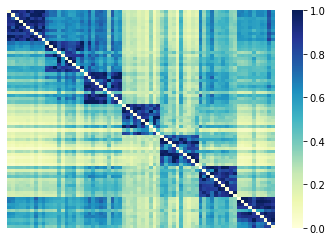

In [15]:
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compare Similarity Between Texts using Jaccard Similarity
num_texts = len(texts)
similarity_matrix = np.zeros((num_texts, num_texts))

for i in range(num_texts):
    for j in range(i + 1, num_texts):  
        set_i = set(texts[i])
        set_j = set(texts[j])
        
        # Take the intersection of the sets
        intersection = set_i.intersection(set_j)
        union = set_i.union(set_j)
        
        # Calculate Jaccard similarity
        if len(union) > 0:
            score_ij = len(intersection) / len(union)
        else:
            score_ij = 0.0
        
        similarity_matrix[i, j] = score_ij
        similarity_matrix[j, i] = score_ij  # Symmetric matrix

# Normalize the similarity matrix
scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(similarity_matrix)
# Plot the heatmap
sns.heatmap(normalized_matrix, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.show()


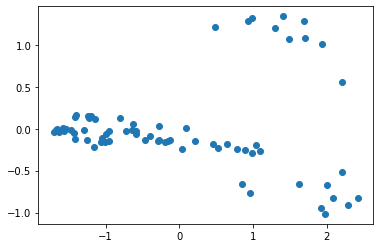

In [16]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_matrix = pca.fit_transform(normalized_matrix)

# Scatter plot of reduced matrix
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1])
plt.show()


In [17]:
"""
Some utility functions for text processing.
"""
import random

def split_text(text, chunk_size, overlap):
    """
    Splits text into a list of chunks of some size with some overlap.
    """
    words = text.split()
    chunks = []

    if overlap > chunk_size:
        overlap = chunk_size
    
    for i in range(0, len(words)-chunk_size+1, chunk_size-overlap):
        chunk = ' '.join(words[i:i+chunk_size])
        chunks.append(chunk)
    
    return chunks

def get_random_query(text, min_len, max_len, n_samples):
    """
    Given some text, generate a number of random substring of size ranging [min_len, max_len].
    """
    words = text.split()

    if min_len > max_len or min_len < 1:
        raise ValueError("Invalid size parameters.")
    if max_len > len(words):
        raise ValueError("Max size length too large.")

    queries = []
    # generate random samples
    for i in range(n_samples):
        # get random index to look at
        query_len = random.randint(min_len, max_len)
        rand_idx = random.randint(0, len(words) - query_len)

        query = ' '.join(words[rand_idx : rand_idx+query_len])
        queries.append(query)

    return queries

def explode_list(some_list):
    """
    Explode a list of lists to one list.
    """
    return [x for sublist in some_list for x in sublist]


In [19]:
# Load the query data
with open("./wiki_hard_test_25-50.pkl", "rb") as file:
    query_file = pickle.load(file)

query_df = pd.DataFrame(query_file)

# Example: Extracting text from the DataFrame and removing stopwords
stop_words = set(stopwords.words('english'))

queries = [
    [word for word in word_tokenize(str(doc).lower()) if word not in stop_words]
    for doc in query_df['text']
]

bm25 = BM25()
bm25.fit(texts)
scores = [bm25.search(query) for query in queries]


In [20]:
results = []
for query, score_list in zip(queries, scores):
    for score, doc in zip(score_list, texts):  # Using 'texts' after tokenization
        score = round(score, 3)
        snippet = ' '.join(doc)
        # Append results to the list
        results.append({
            'query': query,
            'score': score,
            'snippet': snippet,
        })

results_df = pd.DataFrame(results)
print(results_df)

                                                    query   score   
0       [position, voted, officers, ., time, ,, free, ...  27.789  \
1       [position, voted, officers, ., time, ,, free, ...  18.750   
2       [position, voted, officers, ., time, ,, free, ...  13.999   
3       [position, voted, officers, ., time, ,, free, ...  18.492   
4       [position, voted, officers, ., time, ,, free, ...  17.754   
...                                                   ...     ...   
122495  [history, articles, ,, battlefield, news, (, c...  29.795   
122496  [history, articles, ,, battlefield, news, (, c...  41.161   
122497  [history, articles, ,, battlefield, news, (, c...  24.771   
122498  [history, articles, ,, battlefield, news, (, c...  39.630   
122499  [history, articles, ,, battlefield, news, (, c...  81.506   

                                                  snippet  
0       andrew jackson ( march 15 , 1767 – june 8 , 18...  
1       george washington ( february 22 , 1732 , 17

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(results_df['score'], bins=20, kde=True)
plt.title('Distribution of BM25 Scores')
plt.xlabel('BM25 Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
scores = bm25.search(query)

for score, doc in zip(scores, corpus):
    score = round(score, 3)
    snippet = ' '.join(doc.split()[:20]) 
    print(str(score) + '\t' + snippet + '...')


2.535	The Qing dynasty, officially the Great Qing (), was the last dynasty in the imperial history of China. It was...
0.624	The Ming dynasty (), officially the Great Ming, was the ruling dynasty of China from 1368 to 1644 following the...
0.385	The Tang dynasty (, ; ), or Tang Empire, was an imperial dynasty of China that ruled from 618 to...
1.021	The Sui dynasty (, ) was a short-lived imperial dynasty of China of pivotal significance (581-618). The Sui unified the...
0.4	The Han dynasty () was the second imperial dynasty of China (202 BC – 220 AD), established by Liu Bang...
0.426	The Qin dynasty, or Ch'in dynasty in Wade–Giles romanization, was the first dynasty of Imperial China, lasting from 221 to...
0.394	The Zhou dynasty ( ; Old Chinese (B&S): *tiw) was a Chinese dynasty that followed the Shang dynasty and preceded...
2.743	The Shang dynasty (), also historically known as the Yin dynasty (), was a Chinese dynasty that ruled in the...
2.216	The Song dynasty (; ; 960–1279) was a

In the code chunk above, we printed each corpus's BM25 relevance score along with the original text, note that this isn't sorted in decreasing order of the relevance score yet, which is usually what we want to do in a real world setting. That is to find the more relevant document, sort them in decreasing order and present them to the user. Also here, we are computing the scores for every document, this becomes computationally expensive when we start have a large corpus size. Thus search engine uses **inverted index** to speed things up. An inverted index consists of a list of all the unique words that appear in any document, and for each word, a list of the documents in which it appears, this allows us to quickly find the documents that contains the term in our query and only then do we compute the relevance score for this smaller recall set. This [link](https://www.elastic.co/guide/en/elasticsearch/guide/master/inverted-index.html) contains a good high level description of this concept. 

## ElasticSearch BM25

We can see BM25 in action to rank documents using ElasticSearch, this notebook isn't an ElasticSearch tutorial, so hopefully, the reader are some what familiar with the tool, if not, each code chunk contains links to some helpful references.

We will follow the standard process of creating the index to store our documents, add some sample documents to the index and provide a query against the index to return the relevant documents sorted in decreasing order based on the relevance score, which will be based on BM25.

In [66]:
# import json
# import requests

# # Elasticsearch settings
# settings = {
#     'settings': {
#         'index': {
#             'number_of_shards': 1,
#             'number_of_replicas': 1,
#             'similarity': {
#                 'default': {
#                     'type': 'BM25'
#                 }
#             }
#         }
#     },
#     'mappings': {
#         '_doc': {
#             'properties': {
#                 'title': {
#                     'type': 'text',
#                     'analyzer': 'english'
#                 }
#             }
#         }
#     }
# }

# # Elasticsearch server URL
# url = 'http://localhost:9200/experiment'

# # Headers for the request
# headers = {'Content-Type': 'application/json'}

# # Try connecting to Elasticsearch
# try:
#     response = requests.put(url, data=json.dumps(settings), headers=headers)
#     print(response.text)
# except requests.ConnectionError as e:
#     print(f"ConnectionError: {e}")


ConnectionError: HTTPConnectionPool(host='localhost', port=9200): Max retries exceeded with url: /experiment (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f671b91f290>: Failed to establish a new connection: [Errno 111] Connection refused'))


In [252]:
# # indexing document
# # https://www.elastic.co/guide/en/elasticsearch/reference/current/docs-bulk.html
# # https://www.elastic.co/guide/en/elasticsearch/guide/master/index-doc.html

# # a document is uniquely identified by the index, the type and id
# # it's worth noting that there's a note on removing the capabilities of
# # having multiple types under one index, and going forward the type will
# # just to set to '_doc'
# # https://www.elastic.co/guide/en/elasticsearch/reference/current/removal-of-types.html
# url = 'http://localhost:9200/experiment/_doc'

# for document in corpus:
#     # we insert the document into the 'title' field
#     data = {'title': document}
#     response = requests.post(url, data=json.dumps(data), headers=headers)
    
# response

In [53]:
# def search(query, headers):
#     url = 'http://localhost:9200/experiment/_doc/_search'
#     response = requests.get(url, data=json.dumps(query), headers=headers)
    
#     # the response contains other information, such as time it took to
#     # give the response back, here we are only interested in the matched
#     # results, which are stored under 'hits'
#     search_hits = json.loads(response.text)['hits']['hits']

#     print('Num\tRelevance Score\tTitle')
#     for idx, hit in enumerate(search_hits):
#         print('%s\t%s\t%s' % (idx + 1, hit['_score'], hit['_source']['title']))

In [253]:
# # match query
# # https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-match-query.html
# query = {
#     'query': {
#         'match': {
#             # search against the 'title' field
#             'title': 'The intersection of graph survey and trees'
#         }
#     }
# }
# search(query, headers={'Content-Type': 'application/json'})

In [12]:
# # we can delete this experimental index to prevent occupying space
# response = requests.delete('http://localhost:9200/experiment')
# response

<Response [200]>

# Reference

- [Wiki: Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25)
- [Blog: BM25 The Next Generation of Lucene Relevance](https://opensourceconnections.com/blog/2015/10/16/bm25-the-next-generation-of-lucene-relevation/)
- [Blog: Practical BM25 - Part 1: How Shards Affect Relevance Scoring in Elasticsearch](https://www.elastic.co/blog/practical-bm25-part-1-how-shards-affect-relevance-scoring-in-elasticsearch)
- [Blog: Practical BM25 - Part 2: The BM25 Algorithm and its Variables](https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables)
- [Blog: Practical BM25 - Part 3: Considerations for Picking b and k1 in Elasticsearch](https://www.elastic.co/blog/practical-bm25-part-3-considerations-for-picking-b-and-k1-in-elasticsearch)